# 1. Importing needed libraies 

We will need OpenCV to load images, and pytorch for deep learning. We will import other modules as needed.

In [24]:
import torch
import cv2
import numpy as np

# 2. Reading an Image

In [3]:
im = cv2.imread('images/cat.jpg')

### Displaying the image

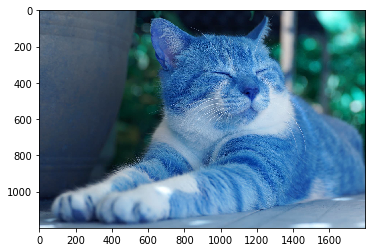

In [4]:
import matplotlib.pyplot as plt
plt.imshow(im)

## Converting to the right color space

OpenCV loads images in BGR color space by default. `matplotlib` and pretrained `pytorch` models expect image in RGB color space. Thus, we need to convert it to RGB color space.

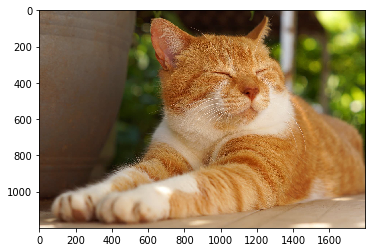

In [5]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

# 3. Load pretrained model and make a prediction

### 3.1 Loading the model
For this part, we load the pretrined deep learning model from `torchvision.models`. The model of choice is the [ResNet-18](https://pytorch.org/vision/stable/models.html) [1] model. You will notice that the model is set to evaluation mode. This is because the model has Dropout layers enabled by default, and Dropout has been shown to perform poorly in evaluation mode. You can learn more about dropout in [this resource](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5) [2]

In [6]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)

# We need to call the eval() method to set the model in evaluation mode. 
model = model.eval()

### 3.2 Applying the necessary transforms
There are a few things we need to do in order to make a prediciton with the model we loaded.
1. We need to resize the image to match the expected input size of the model $(224\times 224)$.
2. The CNN expects the images to be normalized to match the ImageNet distribution (mean and standard deviation).
3. Finally, PyTorch Convolutional Neural Networks (CNNs) expect the input to be a 4D tensor of shape $(N, C, H, W)$, where $N$ is the batch size, $C$ is the number of channels, and $H$ and $W$ are the height and width of the image. 

In [7]:
import torchvision.transforms as transforms

# Steps 1 and 2: Define a transform to pre-process the image.
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Step 3: Apply the transforms and add a dimension B for batch size of 1.
t = transform(im).unsqueeze(0)

### 3.3 Making a prediction
The model will output a tensor of shape $(B, 1000)$, where $B$ is the batch size. We will use the `torch.argmax` function to get the index of the highest probability. This will give us the predicted class index. In order to convert that to a class label, we will use the `classes.txt` file. 

In [8]:
# Load classes into a list
with open('classes.txt', 'r') as f:
    CLASSES = f.readlines()
    
# Pass the image to the model and get the predictions.
out = model(t).argmax(dim=1).item()

# Print the output class
CLASSES[out]


'tiger cat\n'

Putting it all together, we will write a function that takes in an image and returns the predicted class label.

In [9]:
def predict(img_path):
    im = cv2.imread(img_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    t = transform(im).unsqueeze(0)
    out = model(t).argmax(dim=1)
    return CLASSES[out[0]]

Let's make some predictions!

In [10]:
predict('images/cat.jpg')

'tiger cat\n'

In [11]:
predict('images/snake.jpg')

'garter snake, grass snake\n'

In [12]:
predict('images/car.jpg')

'sports car, sport car\n'

# 4. What about deep features

Deep convolutional neural networks (CNNs) are componsed of many layers, the output of each layer is considered a "feature map". Shallow (low level) features are present in the beginning layers whereas the high level features are present in the last layers. In order to extract the deep features from the image, we need to extract the output of last convolutional layer.

Let us print the model to inspect its layers.

In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We can see from above that the last layer is a `Linear` layer with 1000 output nodes representing the 1000 classes. We need to remove this layer from the network and replace it with a `Flatten` layer that will simply pass forward and flatten its input (the high level features).

In [15]:
model.fc = torch.nn.Flatten()

In [17]:
# let us test the output of the model now
feats = model(t)
feats.shape

torch.Size([1, 2048])

In [18]:
# Putting it all together in a function
def features(img_path):
    im = cv2.imread(img_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    t = transform(im).unsqueeze(0)
    out = model(t)
    return out.reshape(-1)

In [19]:
f1 = features('images/cat.jpg')
f2 = features('images/snake.jpg')
f3 = features('images/car.jpg')

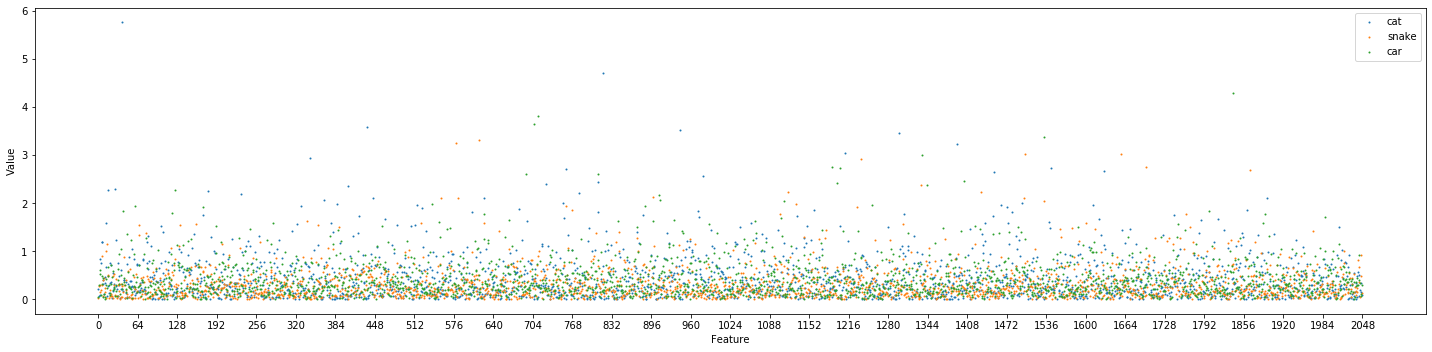

In [35]:

x = np.arange(2048)
plt.figure(figsize=(20,5))
plt.scatter(x, f1.detach().numpy(), label='cat', s=1)
plt.scatter(x, f2.detach().numpy(), label='snake', s=1)
plt.scatter(x, f3.detach().numpy(), label='car', s=1)
plt.legend()
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(np.arange(0, 2049, 64))
plt.tight_layout()
plt.show()

The features might not be easily interpretable to humans, but they are very useful for the machine learning task the nwtwork was trained for. Can we use those features with a different machine learning classifier to make a prediction? (Random forest, SVM, etc.)